<a href="https://colab.research.google.com/github/MScharnberg/IntSys19/blob/master/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook

Intelligent Systems

---

[@mats.scharnberg](mailto:mats.scharnberg@study.hs-duesseldorf.de)

[@christoph.schneider](mailto:christoph.schneider@study.hs-duesseldorf.de)

[@tobias.vossen](mailto:tobias.vossen@study.hs-duesseldorf.de)

## Contents

* Setup
* Data
* Model
* Deployment

## Setup

In [1]:
# Showcase this Notebook?
_SHOWCASE = True #@param ["True", "False"] {type:"raw"}

### Magic

In [2]:
%matplotlib inline
%load_ext tensorboard 

### Libraries

In [3]:
import datetime
import os
from timeit import default_timer as timer
from IPython import display

In [4]:
import numpy as np
print('NumPy version:', np.__version__)

from matplotlib import pyplot as plt

from tensorboard import version
print('TensorBoard version:', version.VERSION)
from tensorboard.plugins.hparams import api as hp

import tensorflow as tf
print('TensorFlow version:', tf.__version__)
from tensorflow import keras
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Conv2DTranspose, Dense, Flatten, Reshape, ReLU

import tensorflow_addons as tfa
print('TensorFlow Addons version:', tfa.__version__)
import tensorflow_datasets as tfds
print('TensorFlow Datasets version:', tfds.__version__)

NumPy version: 1.18.5
TensorBoard version: 2.2.2
TensorFlow version: 2.2.0
TensorFlow Addons version: 0.8.3
TensorFlow Datasets version: 2.1.0


### Utils

In [5]:
def check_env():
  """Check hardware accelerator for training"""

  if not tf.test.gpu_device_name():
    print('WARNING: Running on CPU. Training may take a while...\n')
  else:
    print('WARNING: Running on GPU. Ressources may be temporarly blocked...\n')

In [6]:
def write_config(parameter, metrics):
    """Write config

    Args:
        parameter: Dict
        metrics: Dict
    """

    with tf.summary.create_file_writer('./logs/hparams').as_default():
        hp.hparams_config(
            hparams=list(parameter.values()),
            metrics=list(metrics.values()),
        )

In [7]:
def write_graph():
  input_vector = tf.random.normal((1, _INPUT))
  tf.summary.trace_on(graph=True, profiler=True)
  classification = discriminate(generate(input_vector))

In [8]:
def get_logs():
  """Setup logging
  
  Returns:
    tf.summary.FileWriter

  """

  logdir = os.path.join('logs', datetime.datetime.now().strftime('%Y-%m-%d'))
  print('INFO: Logs will be written to', logdir, '\n')
  return tf.summary.create_file_writer(logdir)

In [9]:
def get_metrics():
    """Metrics
    
    Returns:
        metrics: Dict
    """

    metrics = {
        'loss/generator' : hp.Metric('loss/generator', display_name='Generator', description='Loss of generator'),
        'loss/reconstruction' : hp.Metric('loss/reconstruction', display_name='Reconstruction', description='Reconstruction loss'),
        'loss/discriminator' : hp.Metric('loss/discriminator', display_name='Discriminator', description='Loss of discriminator'),
        'loss/realVSfake' : hp.Metric('loss/realVSfake', display_name='RvsF', description='Real vs. Fake'),
        'eval/kld' : hp.Metric('eval/kld', display_name='KLD', description='Kullback–Leibler divergence'),
        'eval/mse' : hp.Metric('eval/mse', display_name='MSE', description='Mean-squared error'),
    }
    return metrics

In [10]:
def get_metrics_dict(metrics):

  metrics_list = []
  for i in range(4):
    metrics_list.append(tf.keras.metrics.Mean())

  metrics_list.append(tf.keras.metrics.MeanSquaredError())
  metrics_list.append(tf.keras.metrics.KLDivergence())
  metrics_dict = dict(zip(list(metrics.keys()), metrics_list))

  return metrics_dict

## Data

*   Choose dataset
*   Load dataset
*   Explore dataset
*   Preprocess dataset
*   Visualize dataset


### Data constants

In [11]:
_BS = 32 #@param {type:"slider", min:16, max:64, step:16}
_DIM = 28 #@param ["28"] {type:"raw"}
_DS = 'mnist'
_INPUT = 196 # Noise input
_SHAPE = (_DIM, _DIM, 1) # Image shape
_SIZE = '[:100%]' # Dataset size

if _SHOWCASE:
  _SIZE = '[:1%]' # Decrease dataset size for showcase

### Choose dataset

In [12]:
datasets = tfds.list_builders()
print('TF datasets available:', len(datasets))

TF datasets available: 155


### Load dataset

In [13]:
def load_dataset(dataset):
  """Load dataset by means of TFDS (TensorFlow Datasets)
  
  Args:
    dataset: String
  
  Returns:
    train: tf.data.Dataset
    test: tf.data.Dataset
  """

  (train, test), info = tfds.load(dataset,
                            split=['train'+_SIZE, 'test'+_SIZE],
                            as_supervised=True,
                            with_info=True)

  print('Description:', info.description)
  print('Source:', info.homepage)
  print('Total number of examples:', info.splits['train'].num_examples + info.splits['test'].num_examples)
  return train, test

In [14]:
train_dataset, test_dataset = load_dataset(_DS)

Description: The MNIST database of handwritten digits.
Source: http://yann.lecun.com/exdb/mnist/
Total number of examples: 70000


### Explore dataset

In [15]:
def balance(title, *argv):
  """Balance of datasets
  
  Args:
    title: List of Strings
  """

  fig = plt.figure(figsize=(16, 8))

  for num, dataset in enumerate(argv):
    size = tf.data.experimental.cardinality(dataset)

    for image, label in dataset.batch(size).take(-1):
      y, idx, count = tf.unique_with_counts(label)
      fig.add_subplot(1, len(argv), num+1)
      plt.pie(count, autopct='%1.1f%%')
      plt.legend(labels=y.numpy())
      plt.title(title[num] + ' label distribution of ' + str(size.numpy()) + ' examples')

  plt.suptitle('Balance')
  plt.show()

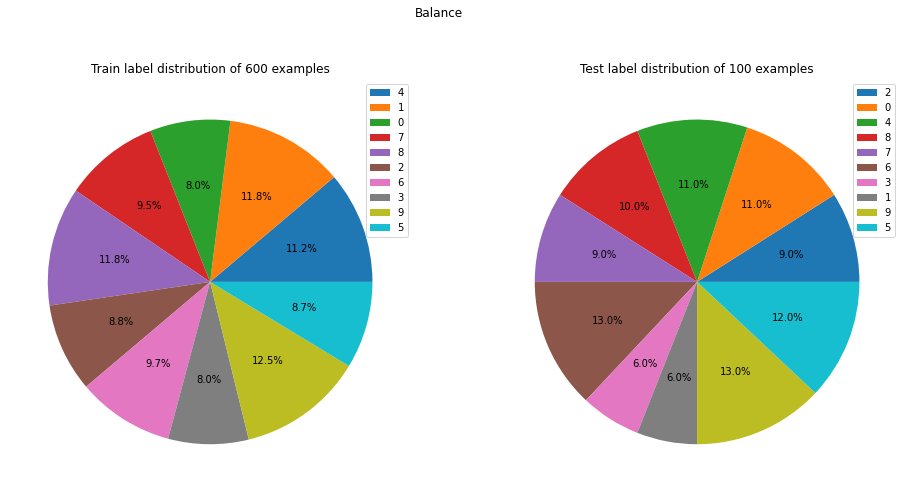

In [16]:
balance(['Train', 'Test'], train_dataset, test_dataset)

### Preprocess dataset

In [17]:
def normalize(image, label):
  """Normalize dataset 
  
  Normalize:
    Cast -> Normalize

  Args:
    image: tf.Tensor as Integer
    label: tf.Tensor as Integer
  
  Returns:
    image: tf.Tensor as Float
    label: tf.Tensor as Float
    noise: tf.Tensor as Float
  """

  image = tf.cast(image, tf.float32)
  image = (image - 127.5) / 127.5 # -1...1
  
  label = tf.cast(label, tf.float32) # (1)
  noise = tf.random.normal((_INPUT, ), mean=tf.math.truediv(label, 10.0)) # (196)
  label = tf.expand_dims(label, -1)

  return image, label, noise

In [18]:
def preprocess(dataset, shuffle=True, batch=True, prefetch=True):
  """Preprocess dataset

  Preprocess: 
    Normalize -> Shuffle -> Batch -> Prefetch
  
  Args:
    dataset: tf.data.Dataset
    shuffle: boolean
    batch: boolean
    prefetch: boolean
  
  Returns:
    dataset: tf.data.Dataset
  """

  dataset = dataset.map(normalize)
  if shuffle: dataset = dataset.shuffle(tf.data.experimental.cardinality(dataset))
  if batch: dataset = dataset.batch(_BS, drop_remainder=True)
  if prefetch: dataset = dataset.prefetch(1)
  return dataset

In [19]:
train_dataset = preprocess(train_dataset)
test_dataset = preprocess(test_dataset)

### Visualize dataset

In [20]:
def visualize(dataset):
  """Visualize dataset
  
  Args:
    dataset: tf.data.Dataset
  """

  dataset = dataset.unbatch()
  fig = plt.figure(figsize=(8, 8))
  i = 0
  for image, label, noise in dataset.take(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(tf.squeeze(image), cmap='gray')
    plt.title(int(label.numpy()))
    plt.axis('off')
    i = i+1

  plt.suptitle('Real data instances')
  plt.show()

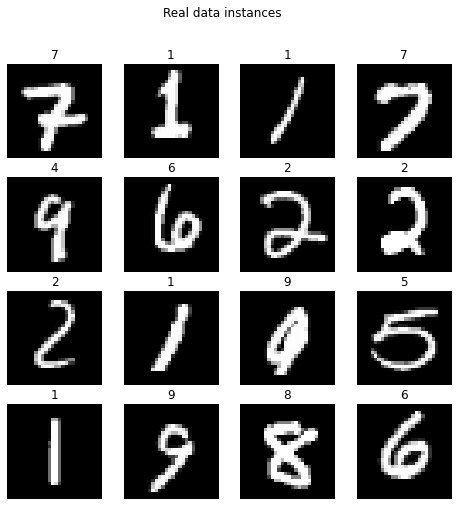

In [21]:
visualize(train_dataset)

## Model

*   Choose model
*   Explore model
*   Compile model
*   Train model
*   Evaluate model

In [22]:
_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}
_LR = 1e-4 # Learning rate
_DEPTH = 5 # Model depth
_INPUT = 196 # Generator input

### Parameters

In [23]:
def get_parameter():
  """Setup parameter
  
  Returns:
    Dict 
  """

  parameter = {
    'model/act' : hp.HParam('model/act', hp.Discrete(['lrelu']), display_name='Activation', description='Layer activation'),
    'model/arch' : hp.HParam('model/arch', hp.Discrete(['dec']), display_name='Architecture', description='Model architecture'),
    'model/init' : hp.HParam('model/init', hp.Discrete(['normal']), display_name='Initialization', description='Weight initialization'),
    'model/lr' : hp.HParam('model/lr', hp.Discrete([1e-4]), display_name='LR', description='Optimizer learning rate'),
    'model/opt' : hp.HParam('model/opt', hp.Discrete(['adam']), display_name='Optimizer', description='Optimizer algorithm'),
    'model/norm' : hp.HParam('model/norm', hp.Discrete(['batch']), display_name='Normalization', description='Layer normalization'),
  }
  return parameter

In [24]:
def get_parameter_dict(parameter):
  parameter_list = []
  for key, value in parameter.items():
    for parameter_value in value.domain.values:
        parameter_list.append(parameter_value)
        break

  parameter_dict = dict(zip(list(parameter.keys()), parameter_list))
  return parameter_dict

### Define layers

In [25]:
def get_activation(activation='relu'):
  """Activation layer
  
  Args:
    avtivation: String

  Returns:
    keras.layers.Layer
  """
  
  if activation == 'lrelu': return keras.layers.LeakyReLU()
  else: return keras.layers.ReLU()

In [26]:
def get_normalization(normalization='batch'):
  """Normalization layer
  
  Args:
    normalization: String

  Returns:
    keras.layers.Layer
  """

  if normalization == 'group': return tfa.layers.GroupNormalization()
  else: return BatchNormalization()

In [27]:
def get_initializer(initializer='normal'):
  """Initializer object
  
  Args:
    initializer: String

  Returns:
    keras.initializers.Initializer
  """
  
  if initializer == 'xavier': return keras.initializers.GlorotNormal()
  else: return keras.initializers.RandomNormal()

In [28]:
def plot_initializer(*args):
  """Visualize initializer"""

  fig = plt.figure(figsize=(8*len(args), 8))

  i = 1
  for arg in args:

    model = keras.Sequential(Dense(_INPUT, kernel_initializer=get_initializer(arg), input_shape=(1, )))
    fig.add_subplot(1, len(args), i)
    plt.hist(model.layers[0].get_weights()[0][0], bins=32)
    plt.title(arg)
    i += 1

  plt.suptitle('Initializer')
  plt.show()

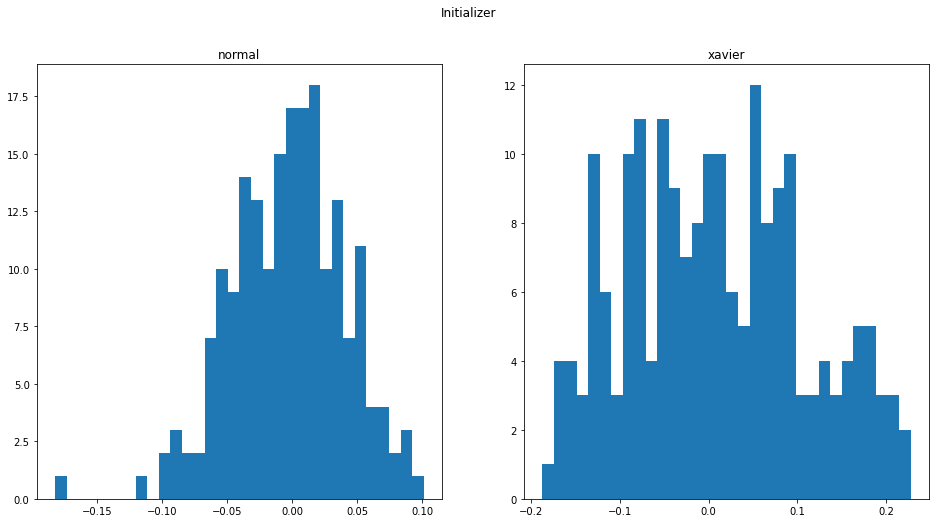

In [29]:
plot_initializer('normal', 'xavier')

### Define model

![GAN](https://github.com/MScharnberg/IntSys19/blob/master/gan.png?raw=1)

Fake data distribution $p_{noise}$

Real data distribution $p_{data}$

---

Generator $G$

Discriminator $D$

---

Noise $z \sim p_{noise}$

Original $x \sim p_{data}$

Copy $x' = G(z)$

Classification $c = D(x \lor x')$




In [30]:
def get_generator(activation='relu', architecture='fcn', initializer='normal', normalization='batch'):
  """Get Generator

  Args:
    parameter: Dict

  Returns:
    keras.Model
  """
  
  first = keras.Input(shape=(_INPUT, ), name='Input')
  layer = first

  layer = Reshape((7, 7, 4))(layer)
    
  for i in range(_DEPTH):
    if i % 2 == 0:
      layer = Conv2DTranspose(8*2**i, (3, 3), 
        padding='same', use_bias=False,
        kernel_initializer=get_initializer(initializer))(layer)

    elif i % 2 == 1:
      layer = Conv2DTranspose(8*2**i, (3, 3), 
        padding='same', strides=2, use_bias=False,
        kernel_initializer=get_initializer(initializer))(layer)

    layer = get_normalization(normalization)(layer)
    layer = get_activation(activation)(layer)

  last = Conv2DTranspose(1, (3, 3), 
    strides=1, padding='same', use_bias=False,
    activation='tanh')(layer)

  return keras.Model(inputs=first, outputs=last, name='Generator')

In [31]:
def get_discriminator(activation='relu', architecture='fcn', initializer='normal', normalization='batch'):
  """Get Discriminator

  Args:
    parameter: Dict
             
  Returns:
    keras.Model
  """

  first = keras.Input(shape=_SHAPE, name='Input')
  layer = first
   
  for i in range(_DEPTH):
    if i % 2 == 0:
      layer = Conv2D(8*2**i, (3, 3), 
        padding='same', use_bias=False,
        kernel_initializer=get_initializer(initializer))(layer)

    if i % 2 == 1:
      layer = Conv2D(8*2**i, (3, 3), 
        strides=2, padding='same', use_bias=False,
        kernel_initializer=get_initializer(initializer))(layer)

    layer = get_normalization(normalization)(layer)
    layer = get_activation(activation)(layer)
  
  layer = Flatten()(layer)

  last = Dense(1)(layer)
  return keras.Model(inputs=first, outputs=last, name='Discriminator')

### Explore model

In [32]:
generator = get_generator()
generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 196)]             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 4)           0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 8)           288       
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 8)           32        
_________________________________________________________________
re_lu (ReLU)                 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 16)        1152      
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 16)        64

In [33]:
discriminator = get_discriminator()
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 8)         72        
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 28, 8)         32        
_________________________________________________________________
re_lu_5 (ReLU)               (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        1152      
_________________________________________________________________
batch_normalization_6 (Batch (None, 14, 14, 16)        64        
_________________________________________________________________
re_lu_6 (ReLU)               (None, 14, 14, 16)      

In [34]:
def explore_model():
  """Explore model
  
  Pipeline: Generator -> Discriminator
    Noise -> Generator -> Image -> Discriminator -> Classification
  """

  # Generator
  noise = tf.random.normal((1, _INPUT))
  image = generator(noise, training=False)

  # Discriminator
  classification = discriminator(image, training=False)
  classification = tf.squeeze(classification, 0) # (1)
  image = tf.squeeze(image) # (28, 28)

  fig = plt.figure(figsize=(8, 4))

  ax1 = fig.add_subplot(1, 2, 1)
  plt.hist(noise, bins=32)
  ax1.title.set_text('Noise')

  ax2 = fig.add_subplot(1, 2, 2)
  ax2.imshow(image, cmap='gray')
  ax2.set_axis_off()
  ax2.title.set_text('Output image')

  plt.suptitle('Generator')
  plt.show()

  fig = plt.figure(figsize=(8, 4))

  ax1 = fig.add_subplot(1, 2, 1)
  ax1.imshow(image, cmap='gray')
  ax1.set_axis_off()
  ax1.title.set_text('Input image')

  ax2 = fig.add_subplot(1, 2, 2)
  ax2.plot([classification, classification], [0, 1], 'r-', label='Classification')
  ax2.legend()
  ax2.title.set_text('Output classification')
  ax2.axes.set_xticks([-1, 0, 1])
  ax2.axes.set_xticklabels(['Copy', 'Unsure', 'Original'])

  plt.suptitle('Discriminator')
  plt.show()

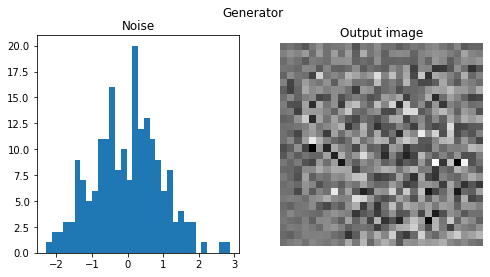

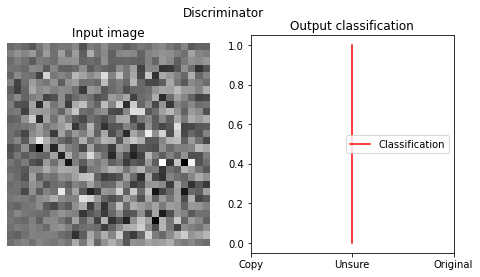

In [35]:
explore_model()

### Compile model

* Loss
   * Generator loss
   * Discriminator loss
* Optimizer
  * [Adam](https://arxiv.org/abs/1412.6980) (Adaptive Moment Estimation)

In [36]:
def generator_loss(fake_output, real_images, fake_images):
  """Generator loss
  
  Args:
    fake_output: tf.Tensor as Float
    real_images: tf.Tensor as Float
    fake_images: tf.Tensor as Float

  Returns:
    generator_loss: tf.Tensor as Float
    reconstruction_loss: tf.Tensor as Float
  """

  generator_loss = loss_fn(tf.ones_like(fake_output), fake_output)
  reconstruction_loss = tf.reduce_mean(tf.abs(real_images - fake_images)) # L1

  return generator_loss * 0.1, reconstruction_loss

In [37]:
def discriminator_loss(real_output, fake_output):
  """Discriminator loss
  
  Args:
    real_output: tf.Tensor as Float
    fake_output: tf.Tensor as Float

  Returns:
    discriminator_loss: tf.Tensor as Float
    loss_quotient: tf.Tensor as Float
  """

  real_loss = loss_fn(tf.ones_like(real_output), real_output)
  fake_loss = loss_fn(tf.zeros_like(fake_output), fake_output)
  discriminator_loss = real_loss + fake_loss
  loss_quotient = real_loss / fake_loss
  
  return discriminator_loss, loss_quotient

In [38]:
def optimizer(optimizer='adam', learning_rate=1e-4):
  """(Lazy) Adam optimizer with exponential decay
  
  Args:
    algorithm: String
    learning_rate: Float
  
  Returns:
    keras.optimizers.Optimizer
  """
  
  schedule = keras.optimizers.schedules.ExponentialDecay(
      learning_rate,
      decay_steps=10,
      decay_rate=0.96)
  
  if optimizer == 'sgd': return tf.keras.optimizers.SGD()
  else: return tf.keras.optimizers.Adam()

### Train model

#### Train step

In [39]:
def train_step(real_images, noise, metrics):
  """Train step
  
  Step:
    Generate fake images -> Update evaluation metrics -> 
    Classify fake/real images -> Compute losses -> 
    Update loss metrics -> Compute gradients -> Apply gradients

  Args:
    real_images: tf.Tensor as Float
    noise: tf.Tensor as Float
    metrics: Dict
  """
  # persistent=True for single application
  # with tf.GradientTape(persistent=True) as tape:
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

    fake_images = generator(noise, training=True)
    
    real_output = discriminator(real_images, training=True)
    fake_output = discriminator(fake_images, training=True)
    metrics['eval/kld'].update_state(real_images, fake_images)
    metrics['eval/mse'].update_state(real_images, fake_images)

    gen_loss, rec_loss = generator_loss(fake_output, real_images, fake_images)
    metrics['loss/generator'].update_state(gen_loss)
    metrics['loss/reconstruction'].update_state(rec_loss)

    disc_loss, realVSfake = discriminator_loss(real_output, fake_output)
    metrics['loss/discriminator'].update_state(disc_loss)
    metrics['loss/realVSfake'].update_state(realVSfake)

    summed_gen_loss = gen_loss + rec_loss

  gradients_of_generator = gen_tape.gradient(summed_gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

#### Train run

In [40]:
def train_run(dataset, parameter, metrics):
  """Train run
  
  Train:
    Iterate over epochs -> Iterate over batches -> Train step per batch ->
    Save (and reset) metrics

  Args:
    dataset: tf.data.Dataset
    parameter: Dict
    metrics: Dict
  """

  start = timer()

  print('\t|Loss\t\t\t\t|Evaluation\t|Time')
  print('Epoch\t|Gen\tRec\tDis\tRvsF\t|KLD\tMSE\t|ELA\tETA')

  for epoch in range(1, _EPOCHS + 1): # Iterate over epochs

    epoch_start = timer()
    output = [epoch, _EPOCHS] 

    for batch in dataset: # Iterate over batches
      train_step(batch[0], batch[2], metrics)
    
    display.clear_output(wait=True)
    fig = plt.figure(figsize=(8, 8))

    i = 0
    for image, label, noise in dataset.unbatch().take(16):

      fake_image = generator(tf.expand_dims(noise, 0), training=False)
      fig.add_subplot(4, 4, i+1)
      plt.imshow(tf.squeeze(fake_image), cmap='gray')
      plt.title(int(label.numpy()))
      plt.axis('off')
      i = i+1

    # tf.summary.scalar('optimizer/lr', optimizer(learning_rate=_LR).lr(epoch), step=epoch)

    plt.suptitle('Fake data instances')
    plt.show()

    for key, metric in metrics.items(): # Save scalar metrics
      tf.summary.scalar(key, metric.result(), step=epoch)
      output.append(metric.result())
      metric.reset_states()

    output.append((timer() - start) / 60)
    output.append(((timer() - epoch_start) * (_EPOCHS - epoch)) / 60)
    print('%i/%i\t|%.2f\t%.2f\t%.2f\t%.2f\t|%.2f\t%.2f\t|%.1f m\t%.1f m' % tuple(output))

#### Train

In [41]:
def coldstart():
  check_env()
  print('INFO: Training in showcase mode with reduced dataset size and training epochs...')
  %rm -rf logs/ # Remove training logs

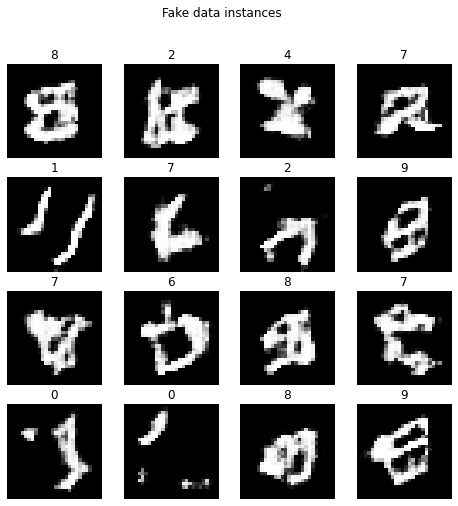

100/100	|0.30	0.34	0.42	0.96	|0.53	1.09	|3.8 m	0.0 m


In [42]:
coldstart()

parameter = get_parameter()
parameter_dict = get_parameter_dict(parameter)

metrics = get_metrics()
metrics_dict = get_metrics_dict(metrics)

write_config(parameter, metrics)

logdir = './logs'

run = 1
for act in parameter['model/act'].domain.values: # Iterate over layer activations
  for arch in parameter['model/arch'].domain.values: # Iterate over model architectures 
    for init in parameter['model/init'].domain.values: # Iterate over weigth initializers
      for lr in parameter['model/lr'].domain.values: # Iterate over optimizer learning rate
        for norm in parameter['model/norm'].domain.values: # Iterate over layer normalization
          for opt in parameter['model/opt'].domain.values: # Iterate over optimizer algorithms

            # Write
            parameter_dict['model/act'] = act
            parameter_dict['model/arch'] = arch
            parameter_dict['model/init'] = init
            parameter_dict['model/lr'] = lr
            parameter_dict['model/norm'] = norm
            parameter_dict['model/opt'] = opt

            print('\n+++ Run', run, '+++\n')
            print('Act\t|Arch\t|Init\t|LR\t|Opt\t|norm')
            print('%s\t|%s\t|%s\t|%.4f\t|%s\t|%s\n' % tuple(parameter_dict.values()))

            rundir = logdir + '/' + str(run)
            writer = tf.summary.create_file_writer(rundir)

            generator = get_generator(activation=act, architecture=arch, initializer=init, normalization=norm)
            discriminator = get_discriminator(activation=act, architecture=arch, initializer=init, normalization=norm)

            loss_fn = keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)

            generator_optimizer = optimizer(optimizer=opt, learning_rate=lr)
            discriminator_optimizer = optimizer(optimizer=opt, learning_rate=lr)
                
            with writer.as_default():
              hp.hparams(parameter_dict)
              train_run(train_dataset, parameter_dict, metrics_dict)

            run += 1

### Evaluate model

In [43]:
if not _SHOWCASE: # Visualize metrics in TensorBoard
  %tensorboard --logdir logs/

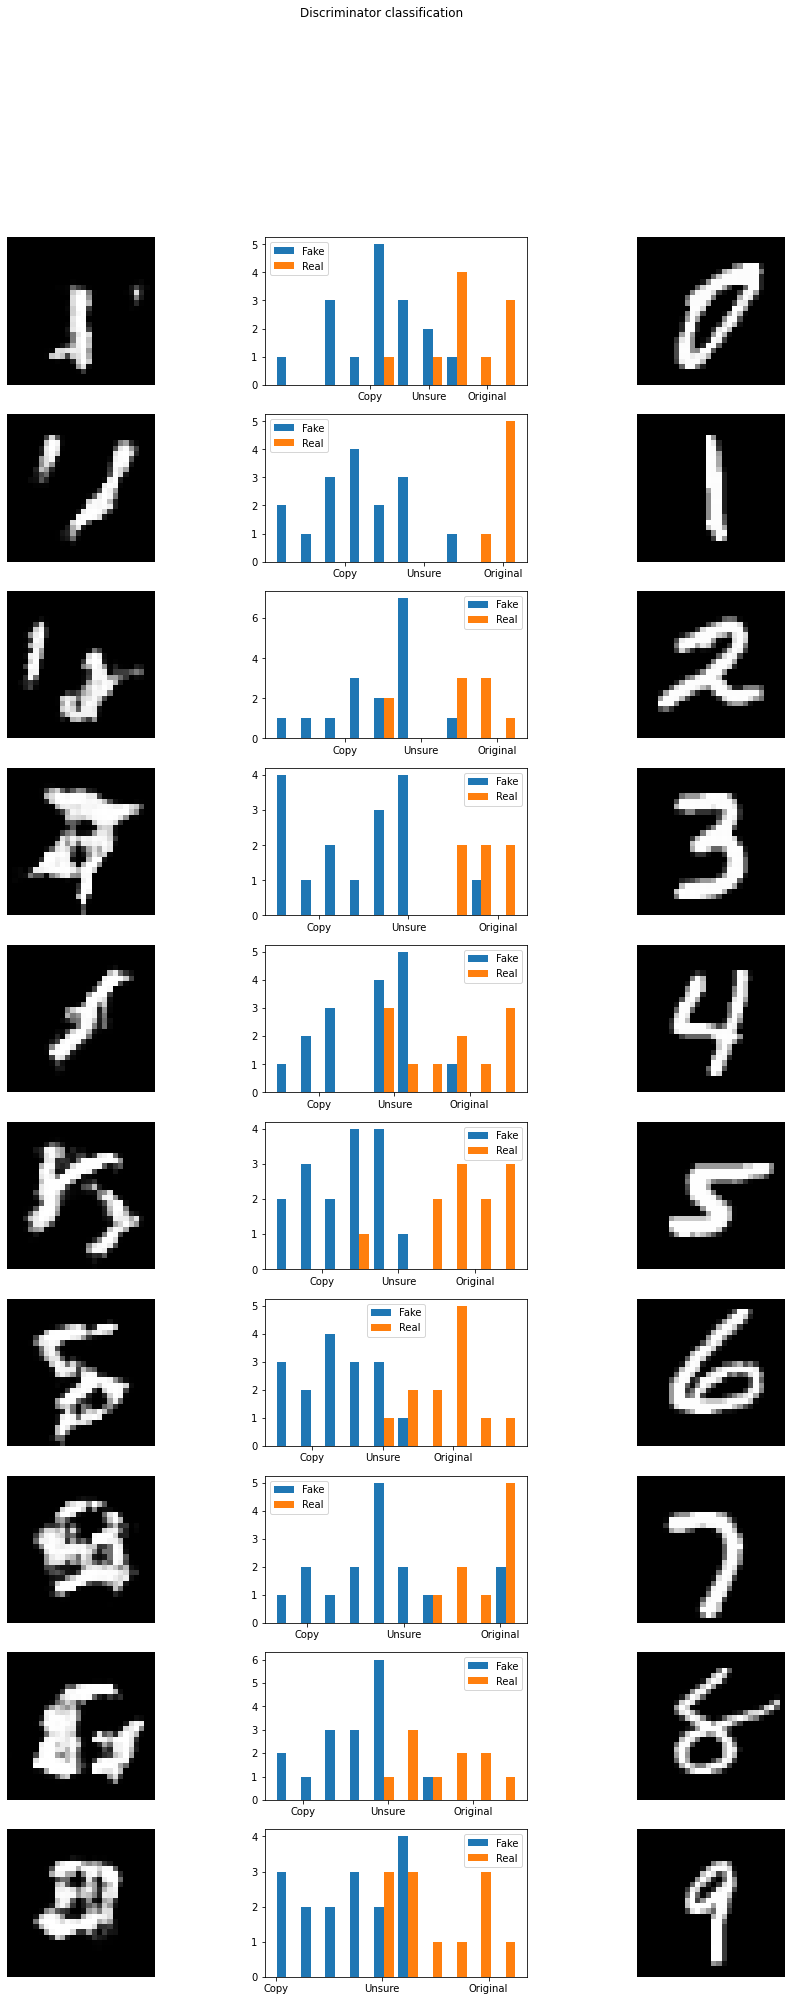

In [44]:
fig = plt.figure(figsize=(16, 32))

for i in range(10):

  # Copy
  noise = tf.random.normal((16, _INPUT, ), mean=tf.math.truediv(float(i), 10.0))
  fake_images = generator(noise, training=False)
  fake_output = discriminator(fake_images, training=False)

  # Original
  real_images = tf.zeros((1, 28, 28, 1), dtype=float)
  for image, label, noise in test_dataset.unbatch().take(-1):
      if label == i:
        real_images = tf.concat([real_images, tf.expand_dims(image, 0)], 0)
        if len(real_images) >= 17: 
          break
          
  real_images = real_images[1:, :, :]
  real_output = discriminator(real_images, training=False)
  
  ax1 = fig.add_subplot(10, 3, 3*i + 1)
  ax1.set_axis_off()
  ax1.imshow(tf.squeeze(fake_images[0]), cmap='gray')

  ax2 = fig.add_subplot(10, 3, 3*i + 2)
  ax2.hist([tf.squeeze(fake_output), tf.squeeze(real_output)])
  ax2.axes.set_xticks([-1, 0, 1])
  ax2.axes.set_xticklabels(['Copy', 'Unsure', 'Original'])
  ax2.legend(['Fake', 'Real'])

  ax3 = fig.add_subplot(10, 3, 3*i + 3)
  ax3.set_axis_off()
  ax3.imshow(tf.squeeze(real_images[0], -1), cmap='gray')

plt.suptitle('Discriminator classification')
plt.show()

## Deployment


*   Use model
*   Export model
*   Export metrics

### Use model

In [45]:
def generate_multiple():
  """Generate multiple digits

  Args:
    num: Integer
  """

  fig = plt.figure(figsize=(8, 8))

  for i in range(16):
    fig.add_subplot(4, 4, i+1)
    label = np.random.randint(0, high=9)
    input_vector = tf.random.normal((1, _INPUT), mean=tf.realdiv(float(label), 10.0))
    plt.title(int(label))
    image = generator(input_vector, training=True)
    plt.imshow(tf.squeeze(image), cmap='gray')
    plt.axis('off')

  plt.suptitle('Fake data instances')
  plt.show()

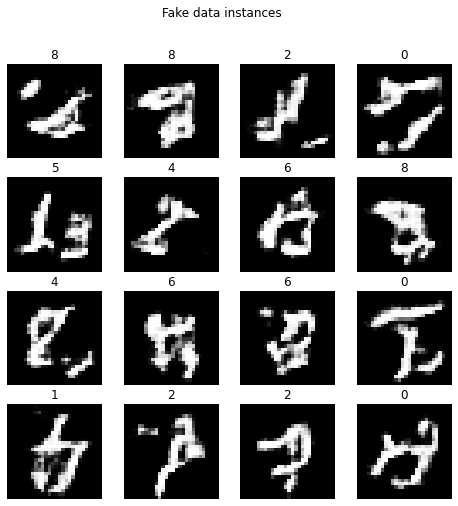

In [46]:
generate_multiple()

### Export model

In [47]:
export = False #@param ["False", "True"] {type:"raw"}
if export: # Export model
  generator.save('./generator.h5')
  discriminator.save('./discriminator.h5')

In [48]:
plot = False #@param ["False", "True"] {type:"raw"}
if plot:
  keras.utils.plot_model(generator, to_file='generator.png', show_shapes=True)
  keras.utils.plot_model(discriminator, to_file='discriminator.png', show_shapes=True)

### Export metrics

In [49]:
upload = False #@param ["False", "True"] {type:"raw"}
if upload:
  !tensorboard dev upload --logdir logs \
      --name "IntSys19" \
      --description "Intelligent Systems"

In [50]:
download = False #@param ["False", "True"] {type:"raw"}
if download:
  !zip -r logs/logs.zip logs/